# Preprocessing and model training


In this notebook, I will prepare my dataframes and then train several classification models off of them and compare results.

Building off of two previous notebooks: (https://github.com/gisthuband/Capstone_2_DS_Job_Locator/blob/main/data_wrangle.ipynb and https://github.com/gisthuband/Capstone_2_DS_Job_Locator/blob/main/exploratory_data_analysis.ipynb), I have constructed and analyzed a dataframe containing information on data science jobs in 2024.

I will use data to create a classification model, that will take my desired salary range and self perceived competitiveness in the job market, and use that to find the best locations and companies to apply for.

The data was found using a kaggle dataset containing 500 job postings for the data science filed in 2024, and a BLS report generated using data science field statistics of 2023.

Kaggle: https://www.kaggle.com/datasets/ritiksharma07/data-science-job-listings-from-glassdoor   

BLS: https://data.bls.gov/oes/#/occInd/One%20occupation%20for%20multiple%20industries 

The samples' (the individual job postings) features will be their upper salary post, lower salary post, company rating, total data scientists in company's state, ratio of job posts to total data scientists in company state, annual mean wage of state, annual median wage of state, ratio of job post to annual mean wage, and ratio of job post to annual median wage.

Each job will receive its label based on geographic region: west, midwest, south, east, or remote.

The models will train based of off the numerical features as x and the regions as y.


In the end, I will input my own desired salary range and my perceived competitiveness in the job market.  The salary range will correspond to the upper and lower salary features.  The perceived competitiveness will become the ratio of posting to state mean, which that in turn will be used to calculate the ratio of posting to state median.  These ratios will determine the state mean and median features in tandem with the inputted salary range.  The company rating, employment in state, and ratio of posts to employment will be automatically taken as their median values as to not overcomplicate the model.  From this input I will get the region label, and from this region label I can use the original dataframe and generate, the top posting cities in that region, along with the companies and the titles of roles accompanying those posts.



## These classification models will be tested and hyperparameter tuned

1.) Random Forest Classification (boosting)

2.) K Nearest Neighbors Classification

3.) Gradient Boosting Classification

4.) DNN Classification

5.) LSTM Classification

In [1]:
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image
%matplotlib inline
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# 1.) Random Forest Classification

In [2]:
df = pd.read_csv('explored_data_v1.csv')

In [3]:
df = df.drop(columns='Unnamed: 0')

In [4]:
df.head()

,upper_salary,lower_salary,state,city,Job Title,Company Rating,company_name,tot_employment_in_state,Annual mean wage(2),Annual median wage(2),total_new_post_rat,range_avg_to_mean_ratio,range_avg_to_median_ratio,labels
0,84000.000000,57000.000000,WI,Onalaska,Associate Stop Loss Underwriter,2.7,The Insurance Center,3090.0,105250.0,101850.0,515.0,0.669834,0.692194,midwest
1,148165.491991,104355.331808,WI,Eau Claire,Marketing Advertising Analyst,3.0,"Net Health Shops, LLC",3090.0,105250.0,101850.0,515.0,1.199624,1.239670,midwest
2,160000.000000,135000.000000,WI,Madison,Manager - IT Infrastructure Engineering,3.9,UW Credit Union,3090.0,105250.0,101850.0,515.0,1.401425,1.448208,midwest
3,84000.000000,59000.000000,WI,Wausau,Associate Stop Loss Underwriter,2.7,The Insurance Center,3090.0,105250.0,101850.0,515.0,0.679335,0.702013,midwest
4,87000.000000,58000.000000,WI,New Berlin,Supply Chain Data Analyst (Day Shift) - New Be...,3.5,DB SCHENKER,3090.0,105250.0,101850.0,515.0,0.688836,0.711831,midwest


In [5]:
df = df.drop(columns=['state','city','Job Title','company_name'])

In [6]:
dum_df = pd.get_dummies(df['labels'])

In [7]:
ready_df = df

In [8]:
dummed_df = pd.concat([df, dum_df],axis=1)

In [9]:
dummed_df = dummed_df.drop(columns='labels')

In [10]:
dummed_df.head()

,upper_salary,lower_salary,Company Rating,tot_employment_in_state,Annual mean wage(2),Annual median wage(2),total_new_post_rat,range_avg_to_mean_ratio,range_avg_to_median_ratio,east,midwest,remote,south,west
0,84000.000000,57000.000000,2.7,3090.0,105250.0,101850.0,515.0,0.669834,0.692194,False,True,False,False,False
1,148165.491991,104355.331808,3.0,3090.0,105250.0,101850.0,515.0,1.199624,1.239670,False,True,False,False,False
2,160000.000000,135000.000000,3.9,3090.0,105250.0,101850.0,515.0,1.401425,1.448208,False,True,False,False,False
3,84000.000000,59000.000000,2.7,3090.0,105250.0,101850.0,515.0,0.679335,0.702013,False,True,False,False,False
4,87000.000000,58000.000000,3.5,3090.0,105250.0,101850.0,515.0,0.688836,0.711831,False,True,False,False,False


In [11]:
features = list(dummed_df.columns[dummed_df.columns != 'west'])
features.remove('south')
features.remove('east')
features.remove('midwest')
features.remove('remote')

In [12]:
X = dummed_df[features]

y = dummed_df[['west','east','south','midwest','remote']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((275, 9), (69, 9), (275, 5), (69, 5))

In [14]:
grid_params = {'n_estimators':[50, 100, 200, 300, 500], 'criterion':['gini','entropy','log_loss'] }

In [15]:
gscv_rfc = GridSearchCV(RandomForestClassifier(), param_grid=grid_params, cv=5, scoring='accuracy')

In [16]:
rfc = gscv_rfc.fit(X_train, y_train)

In [17]:
print (rfc.best_params_)
print (rfc.best_score_)

{'criterion': 'gini', 'n_estimators': 300}
0.9345454545454546


In [18]:
best_rfc = RandomForestClassifier(n_estimators=500, criterion='entropy')
res = best_rfc.fit(X_train, y_train)

In [19]:
y_pred = res.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred, average='weighted')
rf_recall = recall_score(y_test, y_pred, average='weighted')
rf_f1 = f1_score(y_test, y_pred, average='weighted')
rf_cm = confusion_matrix(np.array(y_test).argmax(axis=1), np.array(y_pred).argmax(axis=1))
rf_results = [rf_accuracy, rf_precision, rf_recall, rf_f1, rf_cm]
print (rf_accuracy)
print(rf_precision)
print (rf_recall)
print (rf_f1)
print (rf_cm)

0.9420289855072463
0.9758454106280194
0.9420289855072463
0.9556171978379991
[[10  0  0  0  0]
 [ 1 13  0  0  0]
 [ 1  0 25  0  0]
 [ 2  0  0  7  0]
 [ 0  0  0  0 10]]


# 2.) K Neighbors Classifier

1.) Using the standard scaled x data (x - mean)/std

In [20]:
s_scaler = preprocessing.StandardScaler().fit(X_train)
X_train_s_scaled=s_scaler.transform(X_train)
X_test_s_scaled=s_scaler.transform(X_test)

X_train_s_scaled.shape, X_test_s_scaled.shape

((275, 9), (69, 9))

In [21]:
X_train_mm_scaled=preprocessing.minmax_scale(X_train)
X_test_mm_scaled=preprocessing.minmax_scale(X_test)

X_train_mm_scaled.shape, X_test_mm_scaled.shape

((275, 9), (69, 9))

In [22]:
grid_params_k = {'n_neighbors':[3, 4, 5, 6, 7, 8 ,9, 10],'leaf_size': [20,40,1], 'weights':['uniform','distance'], 'p':[1,2] }

In [23]:
gscv_knn = GridSearchCV(KNeighborsClassifier(), param_grid=grid_params_k, cv=5, scoring='accuracy')

In [24]:
knn_s = gscv_knn.fit(X_train_s_scaled, y_train)

In [25]:
print (knn_s.best_params_)
print (knn_s.best_score_)

{'leaf_size': 20, 'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
0.7527272727272727


In [26]:
knn_s_best = KNeighborsClassifier(n_neighbors=3, leaf_size=20, p=1, weights='distance')
model = knn_s_best.fit(X_train_s_scaled, y_train)
y_pred = model.predict(X_test_s_scaled)

In [27]:
knn_ss_accuracy = accuracy_score(y_test, y_pred)
knn_ss_precision = precision_score(y_test, y_pred, average='weighted')
knn_ss_recall = recall_score(y_test, y_pred, average='weighted')
knn_ss_f1 = f1_score(y_test, y_pred, average='weighted')
knn_ss_cm = confusion_matrix(np.array(y_test).argmax(axis=1), np.array(y_pred).argmax(axis=1))
knn_ss_results=[knn_ss_accuracy, knn_ss_precision, knn_ss_recall, knn_ss_f1, knn_ss_cm]
print (knn_ss_accuracy)
print(knn_ss_precision)
print (knn_ss_recall)
print (knn_ss_f1)
print (knn_ss_cm)

0.7681159420289855
0.8369565217391304
0.7681159420289855
0.7887922705314009
[[10  0  0  0  0]
 [ 1 10  3  0  0]
 [ 2  0 19  1  4]
 [ 1  0  2  5  1]
 [ 0  0  0  0 10]]


2.) Using the min max scaling now (X- Xmin)/range

In [28]:
grid_params_k = {'n_neighbors':[3, 4, 5, 6, 7, 8 ,9, 10],'leaf_size': [20,40,1], 'weights':['uniform','distance'], 'p':[1,2] }

In [29]:
gscv_knn = GridSearchCV(KNeighborsClassifier(), param_grid=grid_params_k, cv=5, scoring='accuracy')

In [30]:
knn_mm = gscv_knn.fit(X_train_mm_scaled, y_train)

In [31]:
print (knn_mm.best_params_)
print (knn_mm.best_score_)

{'leaf_size': 20, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
0.7963636363636364


In [32]:
knn_mm_best = KNeighborsClassifier(n_neighbors=3, leaf_size=20, p=1, weights='distance')
model = knn_mm_best.fit(X_train_mm_scaled, y_train)
y_pred = model.predict(X_test_mm_scaled)


In [33]:
knn_mm_accuracy = accuracy_score(y_test, y_pred)
knn_mm_precision = precision_score(y_test, y_pred, average='weighted')
knn_mm_recall = recall_score(y_test, y_pred, average='weighted')
knn_mm_f1 = f1_score(y_test, y_pred, average='weighted')
knn_mm_cm = confusion_matrix(np.array(y_test).argmax(axis=1), np.array(y_pred).argmax(axis=1))
knn_mm_results=[knn_mm_accuracy, knn_mm_precision, knn_mm_recall, knn_mm_f1, knn_mm_cm]
print (knn_mm_accuracy)
print(knn_mm_precision)
print (knn_mm_recall)
print (knn_mm_f1)
print (knn_mm_cm)

0.463768115942029
0.556603300081561
0.463768115942029
0.49327501902544174
[[ 9  1  0  0  0]
 [ 3  7  2  2  0]
 [ 4  7 11  3  1]
 [ 4  0  3  2  0]
 [ 2  0  5  0  3]]


# 3.) Gradient Boosting Classifier

In [34]:
features = list(ready_df.columns[ready_df.columns != 'labels'])

X = ready_df[features]
y = ready_df['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1, stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((275, 9), (275,), (69, 9), (69,))

In [35]:
grid_params_gb = {'learning_rate':[0.05, 0.1, 0.25, 0.5, 0.75, 1],'n_estimators':[30, 40, 50, 75, 100],'max_depth':[2, 3, 4, 5, 6], 'max_features':[2, 3, 4, 5, 6]}

In [36]:
gcsv_gb = GridSearchCV(GradientBoostingClassifier(), param_grid=grid_params_gb, cv=5, scoring='accuracy')

In [37]:
gb = gcsv_gb.fit(X_train, y_train)

In [38]:
print (gb.best_params_)
print (gb.best_score_)

{'learning_rate': 1, 'max_depth': 3, 'max_features': 5, 'n_estimators': 100}
0.9854545454545456


In [39]:
gb_best = GradientBoostingClassifier(learning_rate=.1, max_depth=4, max_features=6, n_estimators=50)
model = gb_best.fit(X_train, y_train)
y_pred = model.predict(X_test)



In [40]:
gb_accuracy = accuracy_score(y_test, y_pred)
gb_precision = precision_score(y_test, y_pred, average='weighted')
gb_recall = recall_score(y_test, y_pred, average='weighted')
gb_f1 = f1_score(y_test, y_pred, average='weighted')
gb_cm = confusion_matrix(y_test, y_pred)
gb_results=[gb_accuracy, gb_precision, gb_recall, gb_f1, gb_cm]
print (gb_accuracy)
print(gb_precision)
print (gb_recall)
print (gb_f1)
print (gb_cm)

0.9710144927536232
0.9723320158102767
0.9710144927536232
0.9712174724962447
[[14  0  0  0  0]
 [ 0  8  0  0  1]
 [ 0  0 10  0  0]
 [ 0  1  0 25  0]
 [ 0  0  0  0 10]]


## 4.) Deep Neural Network Classification

In [41]:
import tensorflow as tf
import tensorflow.keras as keras

In [77]:
X = dummed_df[features]
y = dummed_df[['west','east','south','midwest','remote']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1, stratify=y)
X_train = tf.convert_to_tensor(X_train)
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(X_train)


275


In [91]:
def get_basic_model():
    
    model = tf.keras.Sequential([
        normalizer,
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(5)
      ])

    model.compile(optimizer='adam',
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy', 'precision', 'recall'])
    return model

In [92]:
model = get_basic_model()
hist=model.fit(X_train, y_train, epochs=150, validation_split=.2, batch_size=16, verbose=False)

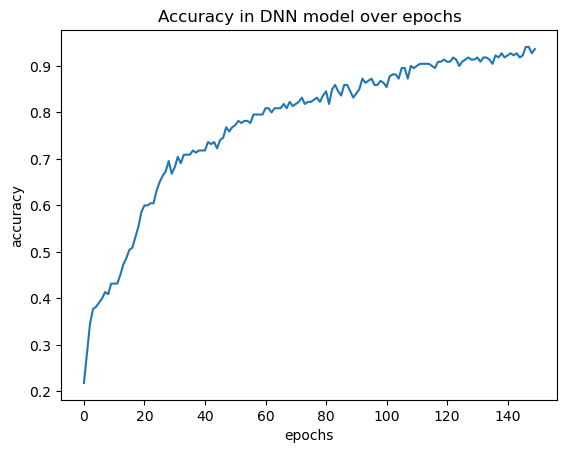

In [95]:
plt.plot(hist.history['accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy in DNN model over epochs')
plt.show()

In [106]:
def dnn_optimize(X_train, y_train, epochs, validation_split, batch_size):
    for x in epochs:
        for y in validation_split:
            for z in batch_size:
                model = get_basic_model()
                hist=model.fit(X_train, y_train, epochs=x, validation_split=y, batch_size=z, verbose=False)
                
            
            plt.plot(hist.history['accuracy'], label='accuracy')
            plt.plot(hist.history['precision'], label='precision')
            plt.plot(hist.history['recall'], label='recall')
            plt.legend()
            plt.xlabel('epochs')
            plt.ylabel('statistic')
            plt.title(f'{x} epochs, {y} valdiation split, and {z} batch size for DNN model')
            plt.show()
    

In [113]:
epochs=[20,50,100,150,200]
validation_split=[.2]
batch_size=[8, 16]

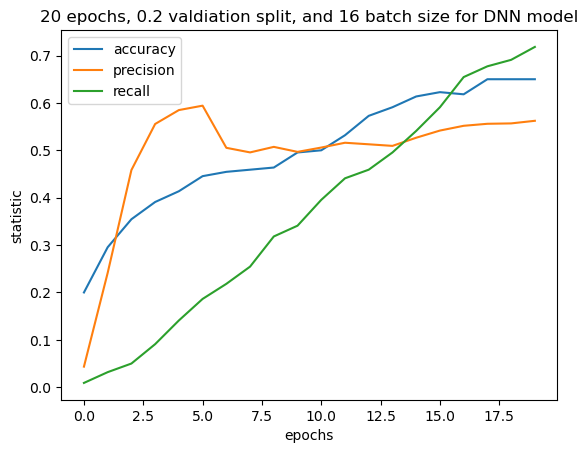

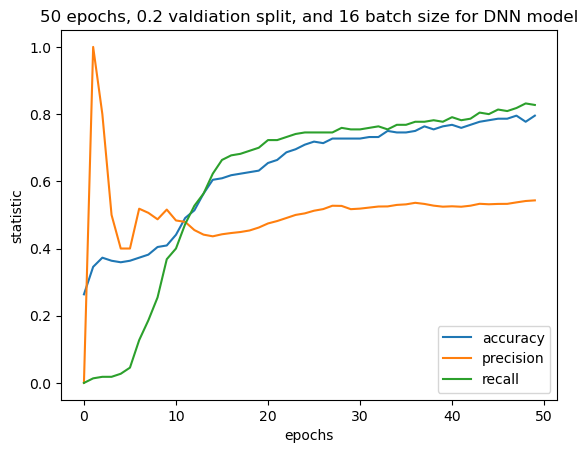

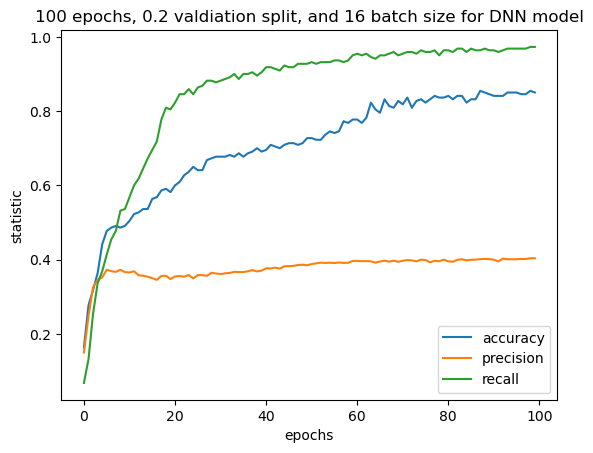

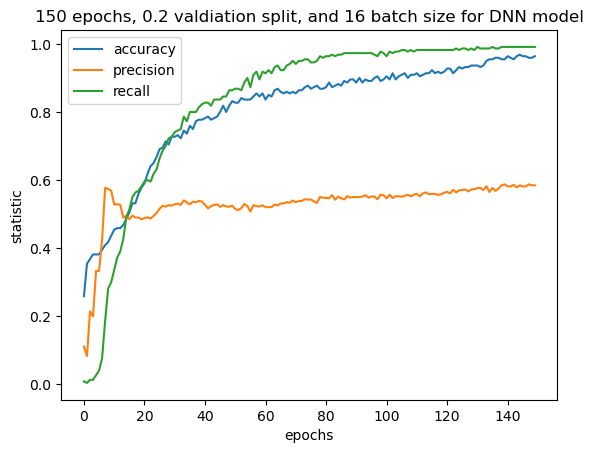

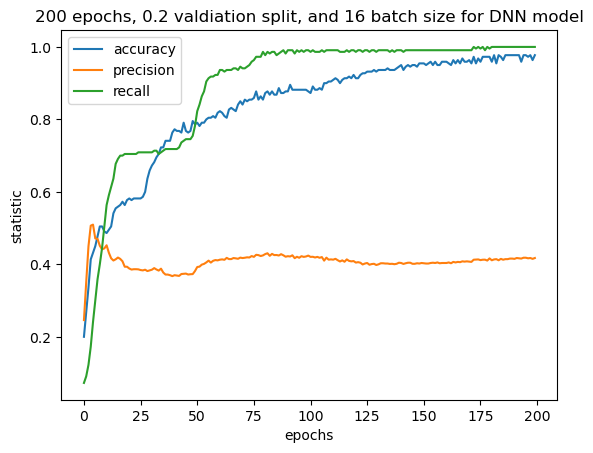

In [114]:
trial = dnn_optimize(X_train, y_train, epochs, validation_split, batch_size)

Considering the 3 statistics found from a confusion matrix, the best performing tuning was 150 epochs, .2 validation split, and 16 batch size 

In [115]:
model = get_basic_model()
hist=model.fit(X_train, y_train, epochs=150, validation_split=.2, batch_size=16, verbose=True)

Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1418 - loss: 1.8729 - precision: 0.0849 - recall: 0.0618 - val_accuracy: 0.0909 - val_loss: 1.8137 - val_precision: 0.0323 - val_recall: 0.0182
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1757 - loss: 1.7350 - precision: 0.0587 - recall: 0.0192 - val_accuracy: 0.1455 - val_loss: 1.6981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2035 - loss: 1.6514 - precision: 0.1666 - recall: 0.0288 - val_accuracy: 0.1455 - val_loss: 1.6330 - val_precision: 0.2500 - val_recall: 0.0364
Epoch 4/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1955 - loss: 1.6034 - precision: 0.2747 - recall: 0.0302 - val_accuracy: 0.1818 - val_loss: 1.5986 - val_precision: 0.3333 - val_recall: 0.0545
Epoch 5/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2571 - loss: 1.5409 - precision: 0.4471 - recall: 0.0590 - val_accuracy: 0.2545 - val_loss

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6971 - loss: 0.7837 - precision: 0.5182 - recall: 0.8597 - val_accuracy: 0.6909 - val_loss: 0.8812 - val_precision: 0.4842 - val_recall: 0.8364
Epoch 35/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7149 - loss: 0.7619 - precision: 0.5089 - recall: 0.8364 - val_accuracy: 0.6909 - val_loss: 0.8667 - val_precision: 0.4842 - val_recall: 0.8364
Epoch 36/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7727 - loss: 0.6349 - precision: 0.5478 - recall: 0.9064 - val_accuracy: 0.6727 - val_loss: 0.8572 - val_precision: 0.4792 - val_recall: 0.8364
Epoch 37/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6945 - loss: 0.8081 - precision: 0.4625 - recall: 0.8211 - val_accuracy: 0.7091 - val_loss: 0.8458 - val_precision: 0.4894 - val_recall: 0.8364
Epoch 38/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7343 - loss: 0.6971 - precision: 0.5179 - recall: 0.8552 - val_accuracy: 0.7091 - val_loss: 0.8351 - val_pr

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8400 - loss: 0.4776 - precision: 0.4724 - recall: 0.9518 - val_accuracy: 0.7818 - val_loss: 0.6489 - val_precision: 0.4397 - val_recall: 0.9273
Epoch 68/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8336 - loss: 0.4743 - precision: 0.4804 - recall: 0.9512 - val_accuracy: 0.7818 - val_loss: 0.6534 - val_precision: 0.4464 - val_recall: 0.9091
Epoch 69/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8413 - loss: 0.4818 - precision: 0.4769 - recall: 0.9498 - val_accuracy: 0.7818 - val_loss: 0.6528 - val_precision: 0.4474 - val_recall: 0.9273
Epoch 70/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7997 - loss: 0.5063 - precision: 0.4728 - recall: 0.9529 - val_accuracy: 0.7818 - val_loss: 0.6467 - val_precision: 0.4474 - val_recall: 0.9273
Epoch 71/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8534 - loss: 0.4688 - precision: 0.4621 - recall: 0.9465 - val_accuracy: 0.7818 - val_loss: 0.6473 - val_pr

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8631 - loss: 0.3816 - precision: 0.4736 - recall: 0.9612 - val_accuracy: 0.7636 - val_loss: 0.6190 - val_precision: 0.4537 - val_recall: 0.8909
Epoch 101/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8682 - loss: 0.3592 - precision: 0.4858 - recall: 0.9678 - val_accuracy: 0.7273 - val_loss: 0.6297 - val_precision: 0.4537 - val_recall: 0.8909
Epoch 102/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8634 - loss: 0.3582 - precision: 0.4840 - recall: 0.9723 - val_accuracy: 0.7818 - val_loss: 0.6161 - val_precision: 0.4579 - val_recall: 0.8909
Epoch 103/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8733 - loss: 0.3697 - precision: 0.4725 - recall: 0.9623 - val_accuracy: 0.7818 - val_loss: 0.6221 - val_precision: 0.4579 - val_recall: 0.8909
Epoch 104/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8627 - loss: 0.3884 - precision: 0.4936 - recall: 0.9652 - val_accuracy: 0.7818 - val_loss: 0.6111 - va

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9240 - loss: 0.2360 - precision: 0.5240 - recall: 0.9762 - val_accuracy: 0.7818 - val_loss: 0.6170 - val_precision: 0.4623 - val_recall: 0.8909
Epoch 134/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9271 - loss: 0.2467 - precision: 0.5328 - recall: 0.9783 - val_accuracy: 0.8000 - val_loss: 0.6052 - val_precision: 0.4712 - val_recall: 0.8909
Epoch 135/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9258 - loss: 0.2339 - precision: 0.5254 - recall: 0.9870 - val_accuracy: 0.7455 - val_loss: 0.6221 - val_precision: 0.4667 - val_recall: 0.8909
Epoch 136/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9411 - loss: 0.2215 - precision: 0.5256 - recall: 0.9853 - val_accuracy: 0.7818 - val_loss: 0.6235 - val_precision: 0.4667 - val_recall: 0.8909
Epoch 137/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9586 - loss: 0.1915 - precision: 0.5143 - recall: 0.9838 - val_accuracy: 0.8000 - val_loss: 0.6170 - va

At the end of the 150th epoch, the accuracy is 95%, precision is 51%, and recall is 97% for the training set, the validation's statistics are: 78% accuracy, 47% precision, and 89% recall.

These precision and recall statistics are quite poor compared to the random forest and gradient boosting models.

Let us see how the test set performs

In [116]:
y_pred = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [123]:
print (X_train)

tf.Tensor(
[[1.48165492e+05 1.04355332e+05 3.81230068e+00 ... 2.58333333e+02
  9.80206598e-01 1.03483659e+00]
 [1.25000000e+05 9.30000000e+04 3.80000000e+00 ... 6.77959184e+02
  7.75855933e-01 8.15319022e-01]
 [1.25000000e+05 6.90000000e+04 3.90000000e+00 ... 1.41470588e+02
  6.97440322e-01 7.10674775e-01]
 ...
 [7.50000000e+04 6.00000000e+04 3.50000000e+00 ... 3.26666667e+02
  6.97314050e-01 7.84610020e-01]
 [1.82000000e+05 1.37000000e+05 4.40000000e+00 ... 4.67272727e+02
  1.46330275e+00 1.59340659e+00]
 [1.48165492e+05 1.04355332e+05 3.80000000e+00 ... 6.77959184e+02
  8.98714584e-01 9.44426748e-01]], shape=(275, 9), dtype=float64)


In [118]:
print (y_pred)

[[-9.93205929e+00  3.66016173e+00  4.66332102e+00 -1.26439559e+00
  -1.17583952e+01]
 [-1.04947176e+01  7.05234766e-01  7.65079308e+00 -7.67334104e-01
  -2.91635680e+00]
 [ 1.22514927e+00  7.98789024e-01 -2.30185318e+00  1.35185039e+00
  -7.33961678e+00]
 [-1.03802090e+01  3.68999863e+00  5.59821653e+00 -1.72363591e+00
  -1.06387634e+01]
 [ 1.81643982e+01  1.97467399e+00 -2.67643147e+01  1.29847736e+01
  -4.56323128e+01]
 [ 1.05645657e+01  1.62052631e+00 -1.09553661e+01  4.26884502e-01
  -2.77431011e+00]
 [-8.90883446e+00 -3.48222423e+00  1.83136845e+00  2.75221181e+00
   7.34128284e+00]
 [-3.09298253e+00 -7.17518628e-01 -1.50019562e+00  1.96728063e+00
   4.51668829e-01]
 [-7.31116772e+00  3.60130858e+00  2.84245372e+00 -1.23346233e+00
  -1.03537245e+01]
 [-1.80788839e+00  4.96269047e-01  2.30068386e-01  2.53618765e+00
  -1.48602190e+01]
 [ 9.84971714e+00  2.80905509e+00 -1.09049320e+01 -2.17761815e-01
  -4.68250179e+00]
 [ 7.40942383e+00  4.34872103e+00 -7.28708935e+00 -1.87629807e+00

In [120]:
dnn_accuracy = accuracy_score(np.array(y_test).argmax(axis=1), np.array(y_pred).argmax(axis=1))
dnn_precision = precision_score(np.array(y_test).argmax(axis=1), np.array(y_pred).argmax(axis=1), average='weighted')
dnn_recall = recall_score(np.array(y_test).argmax(axis=1), np.array(y_pred).argmax(axis=1), average='weighted')
dnn_f1 = f1_score(np.array(y_test).argmax(axis=1), np.array(y_pred).argmax(axis=1), average='weighted')
dnn_cm = confusion_matrix(np.array(y_test).argmax(axis=1), np.array(y_pred).argmax(axis=1))
dnn_results=[dnn_accuracy, dnn_precision, dnn_recall, dnn_f1, dnn_cm]
print (dnn_accuracy)
print(dnn_precision)
print (dnn_recall)
print (dnn_f1)
print (dnn_cm)

0.8260869565217391
0.8469716676238415
0.8260869565217391
0.8223725235067391
[[10  0  0  0  0]
 [ 0 13  1  0  0]
 [ 0  3 17  4  2]
 [ 1  0  0  7  1]
 [ 0  0  0  0 10]]


# In summary:

Here is the performance of the different models, as fitted upon their best hyperparameter adjustments:

RFC: (accuracy: .97, f1: .89)
KNN best scaling: (accuracy: .80 , f1: .77)
GB: (accuracy: .96, f1: .96)
DNN: (accuracy: .83, f1: .82)

The best performing model is the gradient booster classifier, this is most likely due to the error training component.  Gradient Boosting classifiers are robust to outliers, which may have helped pushed its ability to perform higher.  The individual data labels may have seemingly outlier like vales within the label, leading to GB's success for training so well on the error.  

The K Nearest may have performed at such a low level because the clusters were actually difficult to determine in the numerical space given, as reflected by GB's success with such problematic outliers.  Furthermore, the difference in performance between the standard scaled and maxmin scaled data preporcessing goes to show how the data contains points that are outlier-esque based off of the geographical classification.

The random forest performed very well most likely because it was able to generate enough decision trees that were very overfit to the data, and then average those with the very unfit ones successfully.

Deep neural network performed middle of the road in this instance, perhaps it was due to lack of innovation in the layering or the data did not flow into the neurons well.

Overall gradient boosting performed the best, and this and the random forest and deep neural network will be implemented on the final step: the final model construction and execution.



In [125]:
results_df = pd.DataFrame(data={'Random_Forest':rf_results, 'K_Nearest_Standard_Scaled':knn_ss_results, 'K_Nearest_MaxMin_Scaled':knn_mm_results, 'Gradient_Booster':gb_results, 'Deep Neural Network': dnn_results})

In [128]:
results_df = results_df.rename(index={0:'accuracy',1:'precision',2:'recall',3:'f1'})

In [131]:
results_df = results_df.drop(index=4)

In [132]:
results_df.head()

,Random_Forest,K_Nearest_Standard_Scaled,K_Nearest_MaxMin_Scaled,Gradient_Booster,Deep Neural Network
accuracy,0.942029,0.768116,0.463768,0.971014,0.826087
precision,0.975845,0.836957,0.556603,0.972332,0.846972
recall,0.942029,0.768116,0.463768,0.971014,0.826087
f1,0.955617,0.788792,0.493275,0.971217,0.822373


In [133]:
results_df.to_csv('model_comp.csv')